<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen/blob/main/ArGen_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This code generates art by applying mathematical formula ("color generator") to coordinates and additional variables of each pixel ("input values"), interpreting outputs as color values. This works because differences in input values between pixels mean different colors in the final artwork.

Different color generator forumlas provide different patterns in the resulting artwork, and using random variables in color generation provides variety when using the same formula for different artworks. In a way, this code allows for artful visualization of math

Interesting effects can be achieved by adding aditional variables to each pixel along with it's coordinates.

It is also possible to create animations by changin input data on each frame

# Imports

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import colorsys
import os
import lzma
import shutil
import pickle
import types
import ffmpeg
from google.colab import files
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from tensorflow.keras import layers
from zipfile import ZipFile, ZIP_LZMA
from cv2 import VideoWriter, VideoWriter_fourcc
from tensorflow import keras
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import imageio as io

# Functions for creating input values

In [ ]:
'''
Creates a 3D matrix, with 1st and 2nd dimensions representing pixels, 3rd dimension specifying coordinates
'''
def create_pixel_coordinate_matrix(resolution, image_centre, coordinate_width, pixel_ratio):
  resolution_ratio = resolution[0] / resolution[1]
  coordinate_height = coordinate_width / (resolution_ratio * pixel_ratio)

  xmin = image_centre[0] - coordinate_width / 2
  xmax = image_centre[0] + coordinate_width / 2

  # inverts height coordinates to be more intuitive
  # update: i don't remember how it helps
  ymin = (image_centre[1] * -1) - coordinate_height / 2
  ymax = (image_centre[1] * -1) + coordinate_height / 2

  x = np.linspace(xmin, xmax, resolution[0], dtype=np.float32)
  y = np.linspace(ymin, ymax, resolution[1], dtype=np.float32)
  xs, ys = np.meshgrid(x, y)
  del x, y
  coordinates = np.stack([xs, ys], axis=-1)
  del xs, ys

  return coordinates

In [ ]:
'''
these functions create matrices used as additional input values for each pixel,
resulting in specific effects in the final artwork
'''

def make_waves(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = np.cos(distances*freq + phase)
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_pulses(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = (((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1)
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_switches(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1, push=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = ((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1
  sw = (1 / (1 + np.exp(-coss*push))) * 2 - 1
  sw = np.expand_dims(sw, axis=-1)
  return sw


def make_rotation(resolution, image_centre, coordinate_width, pixel_ratio, angle_phase=0, distance_phase=0, angle_freq=1, freq=1, angle_power=1, power=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angles = np.arctan2(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angle_multiplier = ((np.cos(angles*angle_freq+angle_phase)+1)/2)**angle_power
  coss = (((np.cos(distances*freq + distance_phase) + 1)/2) ** power)
  both = (coss * angle_multiplier) * 2 - 1
  sw = np.expand_dims(both, axis=-1)
  return sw

In [ ]:
'''
creates pixel coordinate matrix and appends effects matrices
'''
def create_color_generator_input_matrix(resolution, image_centre, coordinate_width,
                                        pixel_ratio, effects_matrices=None):
  coordinates = create_pixel_coordinate_matrix(resolution, image_centre,
                                               coordinate_width, pixel_ratio)
  
  # concats additional data
  if effects_matrices is not None:
    coordinates = np.concatenate([coordinates, effects_matrices], axis=-1)
  return coordinates

# Color generators

In [ ]:
'''
processing input in parts is useful in case color generator uses a lot of memory
'''
def process_input_in_parts(inp, processing_function, divide_by_n_parts=8):
  blocks = np.array_split(inp, divide_by_n_parts, axis=0)
  outputs = []
  for i, block in enumerate(blocks):
    print("processing block " + str(i+1) + " out of " + str(len(blocks)))
    result = processing_function(block)
    outputs.append(result)

  final_result = np.concatenate(outputs)
  return final_result

In [ ]:
@tf.function
def distance(x):
  return tf.norm(x, axis=-1, keepdims=True)

In [ ]:
'''
Objects of this class on call take 3D matrix of input values and return
generated 3D matrix that can be interpreted as RGB image.
_color_generator_function must be set before use
'''
class ColorGenerator:
  _color_generator_function = None

  def __init__(self, color_generator_function=None):
    self._color_generator_function = color_generator_function

  # assumes color generator function returns are from -1 to 1, converts them to 0..255 ints
  def convert_color_values_to_rgb(self, colors_matrix):
    scaled = ((colors_matrix + 1) / 2) * 255
    integer_colors = scaled.astype(np.uint8)
    return integer_colors

  def __call__(self, input_data):
    color_function_results = process_input_in_parts(input_data,
                                                    self._color_generator_function)
    converted_to_rgb = self.convert_color_values_to_rgb(color_function_results)
    return converted_to_rgb

In [ ]:
'''
assumes color function returns are from -1 to 1, interprets them as HSV values
and converts to 0..255 ints RGB values.
Interpreting results as HSV may provide less chaotic hues/saturation/brightness
'''
def convert_color_values_to_rgb_as_hsv(x):
  converted = (x + 1) / 2
  
  # assignis 0 to pixels with NAN channels
  nan_mask = np.expand_dims(np.isnan(converted).any(axis=-1), axis=-1).repeat(3, axis=-1)
  converted[np.where(nan_mask)] = 0
 
  converted = (hsv_to_rgb(converted) * 255).astype(np.uint8)
  return converted

Randomly initialized keras neural networks with unusual activation functions turned out to be great color generators, so i am using them for this purpose in the rest of the code

In [ ]:
'''
Custom keras layer that splits last dimension and passes it through different
activation functions
'''
class SplitActivation(keras.layers.Layer):

  def __init__(self, activations, split_config=None, split_dim=-1, **kwargs):

    self._split_dim = split_dim
    self._activations = activations
    self._activations_amount = len(self._activations)
    self._is_config_a_list = isinstance(split_config, list)
    self._split_config = None
    
    # assert that split_config size matches with activations amount
    if self._is_config_a_list:
      assert len(split_config) == self._activations_amount, (
        'length of activation sizes list ({}) does not match length of '
        'activations list ({})'
        .format(len(split_config), self._activations_amount))
      self._split_config = split_config
    else:
      self._split_config = self._activations_amount
    
    super(SplitActivation, self).__init__(**kwargs)
    
  def build(self, input_shape):
    split_dim_size = input_shape[self._split_dim]
    
    if self._is_config_a_list:
      assert sum(self._split_config) == split_dim_size, (
        'sum of split sizes ({}) does not match the split dimension size ({})'
        .format(sum(self._split_config), split_dim_size))
    else:
      assert (split_dim_size % self._activations_amount) == 0, (
        'last dimension (size {}) cannot be evenly split across '
        'activations (size {})'
        .format(split_dim_size, self._activations_amount))
    
    super(SplitActivation, self).build(input_shape)
    
  
  def call(self, x):
    split_input = tf.split(x, self._split_config, axis=self._split_dim)
    
    x = tf.concat([activation(input_slice) for input_slice, activation
                   in zip(split_input, self._activations)],
                  axis=self._split_dim)
    return x


In [ ]:
'''
Creates a color generator that draws my favourite patterns to date
'''
class StairsGenerator(ColorGenerator):
  def __init__(self):
    super(StairsGenerator, self).__init__(
      color_generator_function=keras.Sequential([
        keras.layers.Dense(16,
                          bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
        SplitActivation([tf.nn.relu, tf.math.sin]),
        keras.layers.Dense(16,
                          bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                          #bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
        SplitActivation([tf.nn.relu, tf.math.ceil]),
        keras.layers.Dense(16,
                          kernel_initializer=keras.initializers.RandomNormal(0, 0.1),
                          bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
        SplitActivation([tf.nn.relu, tf.math.sin]),

        keras.layers.Dense(3,
                          activation='tanh'),
    ]))

# Creating the image

In [ ]:
color_generator = StairsGenerator()

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


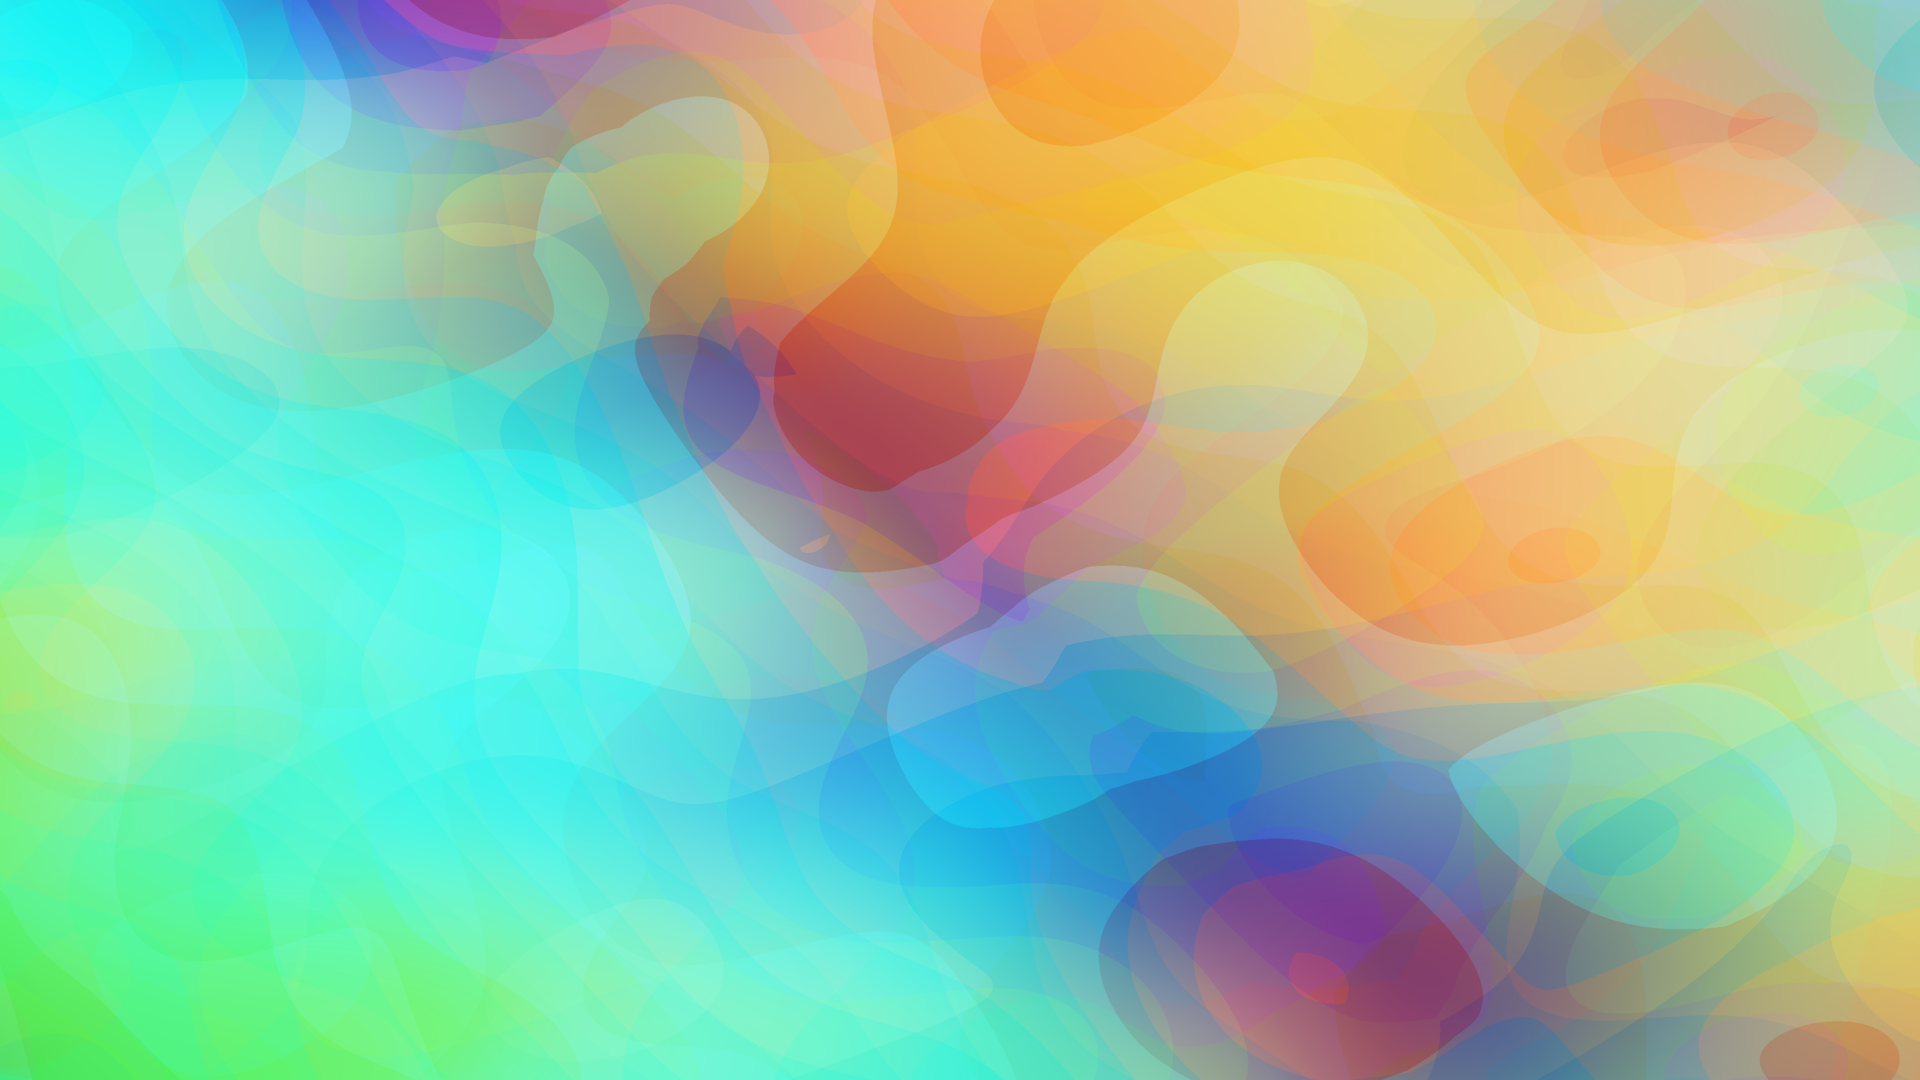

In [ ]:
'''
it is often useful to use a resolution higher than that of a screen when
generating the image, and resize it later on, to smooth out edges
'''
res = (1920 * 2, 1080 * 2)

centre = (0, 0)
width = 50
pixel_ratio = 1
input_matrix = create_color_generator_input_matrix(res, centre, width, pixel_ratio)
color_output_rgb_matrix = color_generator(input_matrix)
Image.fromarray(color_output_rgb_matrix).resize((res[0] // 2, res[1] // 2), resample=PIL.Image.BICUBIC)

# Image with simple effects

In [ ]:
color_generator = ColorGenerator(keras.Sequential([
      #keras.layers.Dense(60,
  #                   kernel_initializer=keras.initializers.RandomNormal(0, 0.5)),
  #SplitActivation([tf.math.cos, tf.nn.relu6, distance]),

  keras.layers.Dense(33, kernel_initializer=keras.initializers.RandomNormal(1, 5)),
  SplitActivation([tf.math.tanh, tf.math.sin,
                   keras.layers.Dense(20, kernel_initializer=keras.initializers.RandomNormal(0, 0.05), activation=tf.sin)]),

  keras.layers.Dense(32, kernel_initializer=keras.initializers.RandomNormal(0, 5),
                     bias_initializer=keras.initializers.RandomNormal(0, 40)),
  SplitActivation([tf.math.tanh, tf.nn.relu6]),
  keras.layers.Dense(32, kernel_initializer=keras.initializers.RandomNormal(0, 5),
                     bias_initializer=keras.initializers.RandomNormal(0, 4)),
  SplitActivation([tf.math.tanh,
                   lambda x: tf.nn.relu6(tf.math.log(x**2))]),
  #keras.layers.Dense(60,),
  #SplitActivation([tf.math.sin]),

  # keras.initializers.RandomNormal(0, 0.25)
  SplitActivation([tf.nn.softmax]),
  keras.layers.Dense(7, kernel_initializer=keras.initializers.RandomNormal(0, 5)),

      keras.layers.Dense(3,
                        activation='tanh'),
    ]))
color_generator.convert_color_values_to_rgb = convert_color_values_to_rgb_as_hsv

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


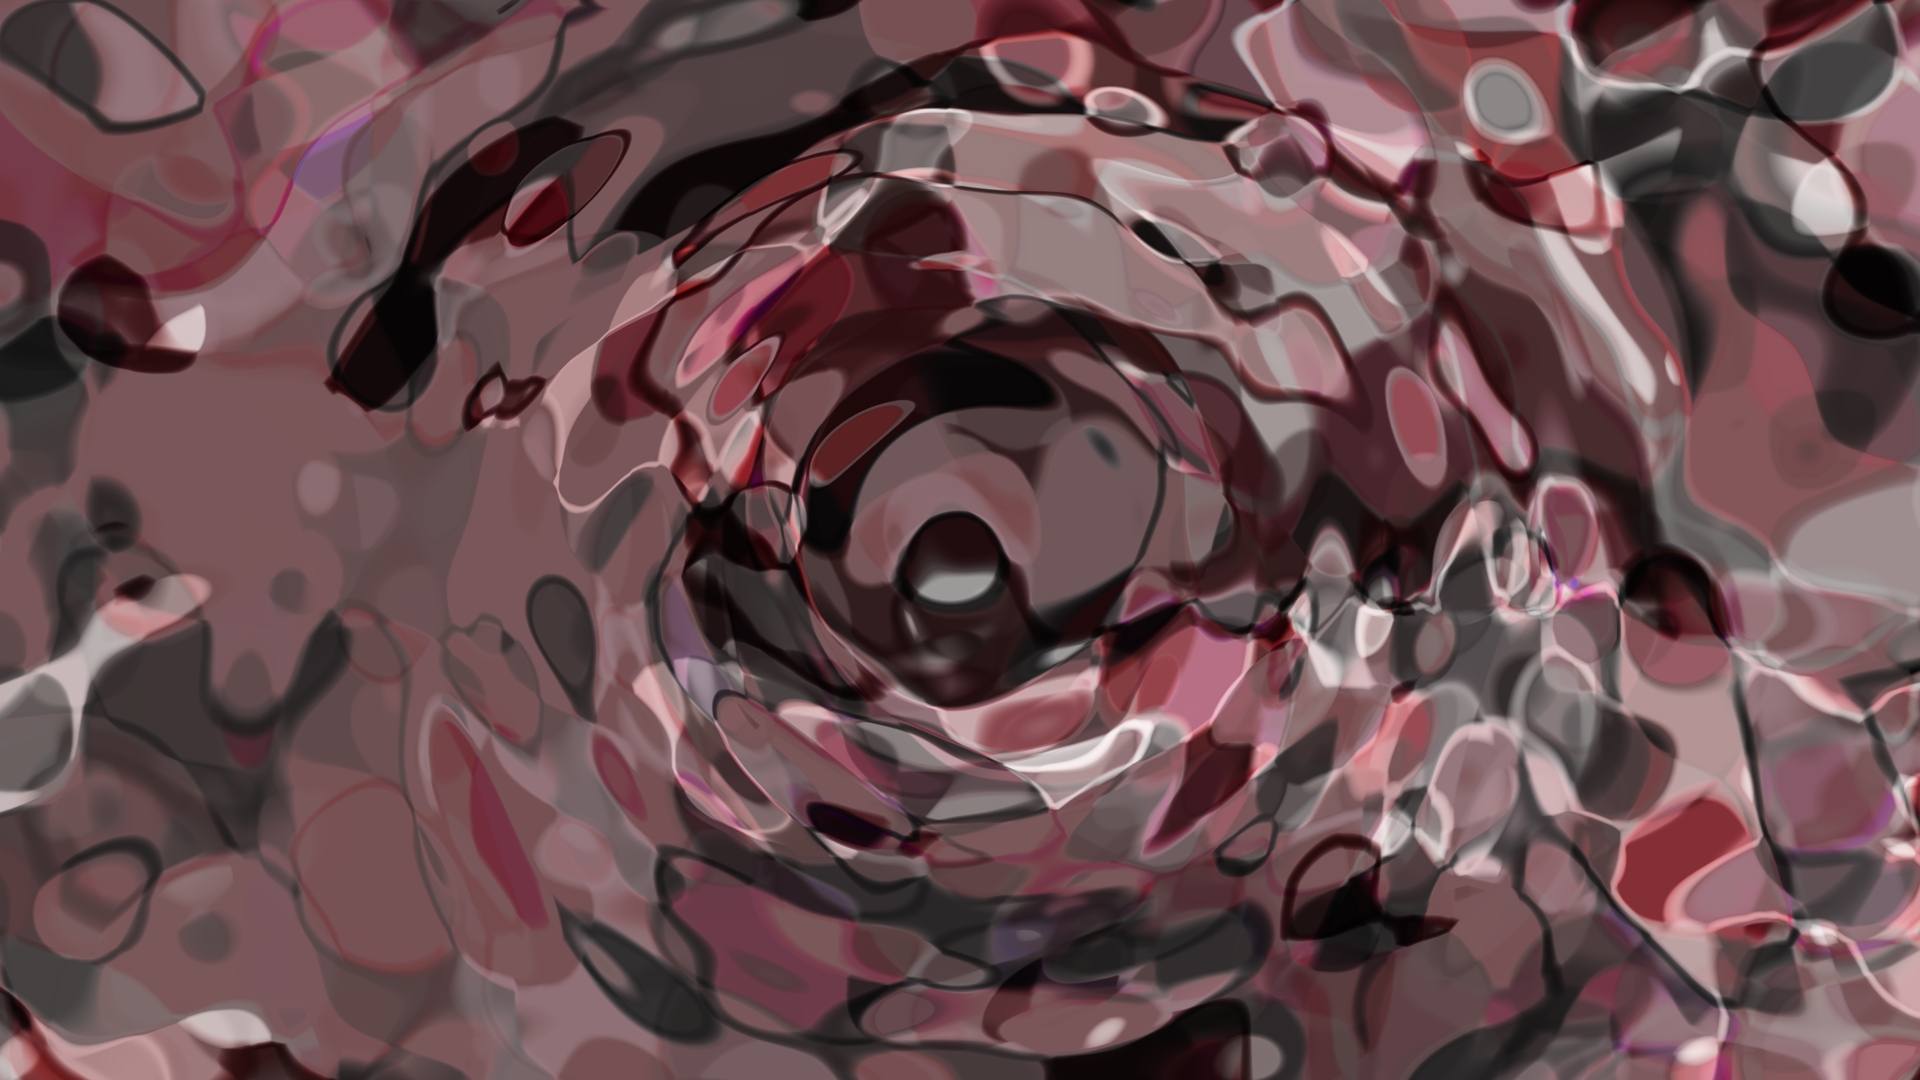

In [ ]:
width = 5

# "make_waves" effect makes wave ripples emminating from the center point
waves_effect = make_waves(res, (0, 0), width, 1, freq=1, phase=np.pi/4)*2

input_matrix = create_color_generator_input_matrix(res, centre, width, pixel_ratio, waves_effect)
color_output_rgb_matrix = color_generator(input_matrix)
Image.fromarray(color_output_rgb_matrix).resize((res[0] // 2, res[1] // 2), resample=PIL.Image.BICUBIC)

# Image with advanced effects

In [ ]:
'''
i wrote the code for this effect a year ago, i cannot explain it at all
'''
def make_input_vortex(i, resolution, centre, original_width, pixel_ratio, seconds, video_fps, invert=False):
  frames_in_animation = seconds * video_fps
  phase = 0 
  whole_rotation_multiplier = 2 * np.pi / frames_in_animation
  #movement_progress = (-np.cos(i * whole_rotation_multiplier + phase) + 1) * 0.5
  #movement_direction = np.sin(i * whole_rotation_multiplier + phase)

  pulsing_phase = (-i * (np.pi * 2 / (frames_in_animation/2)))
  pulse_sin_norm = (np.sin(pulsing_phase) + 1) / 2

  zoom_out_distance = original_width * 0.25
  width = original_width + (pulse_sin_norm**16 * zoom_out_distance)

  mtx = create_color_generator_input_matrix(resolution, centre, width, pixel_ratio)
  dists = np.hypot(mtx[:, :, 0], mtx[:, :, 1])
  hole_radius_overkill = 1
  #hole_radius = (original_width / 1.5) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)
  #hole_radius = (original_width / 2.2) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)
  hole_radius = (original_width / 6) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)

  if not invert:
    holed_distance = -(hole_radius - dists)
  else:
    holed_distance = (hole_radius - dists)

  holed_distance[holed_distance < 0] = np.nan
  del dists
  #rotation_amount = (0.2 / (((holed_distance*(np.pi / 30))**2) + 0.04)) + (i * whole_rotation_multiplier)
  rotation_amount = (0.2 / (((holed_distance*(np.pi / 30))**2) + 0.06)) + (i * whole_rotation_multiplier)

  #subspace_bulge = ((-original_width/4) * np.exp(-(holed_distance - hole_radius/3)**2 / (1 + pulse_sin_norm**16))) + np.sin(i * whole_rotation_multiplier) * 4
  subspace_bulge = ((-original_width/4) * np.exp(-(holed_distance - hole_radius/4)**2 / (1 + pulse_sin_norm**16))) + np.sin(i * whole_rotation_multiplier) * 4

  pulsing = ((((np.sin((holed_distance * (np.pi * 2 / (original_width/0.25))) + (- pulsing_phase + (np.pi/2 + np.pi/5.5))) + 1) / 2)**128) * (original_width*0.25)
             / (holed_distance*0.1 + 0.5))
  del holed_distance

  rotated_x = (mtx[:, :, 1] * np.cos(-rotation_amount) - mtx[:, :, 0] * np.sin(-rotation_amount))
  rotated_y = (mtx[:, :, 1] * np.sin(-rotation_amount) + mtx[:, :, 0] * np.cos(-rotation_amount))
  del mtx
  del rotation_amount

  #consta = np.ones_like(rotated_x) * np.sin(i * whole_rotation_multiplier) * 4
  final_input = np.stack([rotated_y, rotated_x, subspace_bulge, pulsing], axis=-1)
  del rotated_y
  del rotated_x
  del subspace_bulge
  del pulsing
  return final_input

In [ ]:
stairs_generator = StairsGenerator()

In [ ]:
target_resolution = (1920, 1080)
supersampling_multiplier = 8
supersampling_resolution = [size * supersampling_multiplier for size in target_resolution]
input_data = make_input_vortex(0, supersampling_resolution, centre, 50, 1,
                               seconds=20,
                               video_fps=60,
                               invert=False)

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


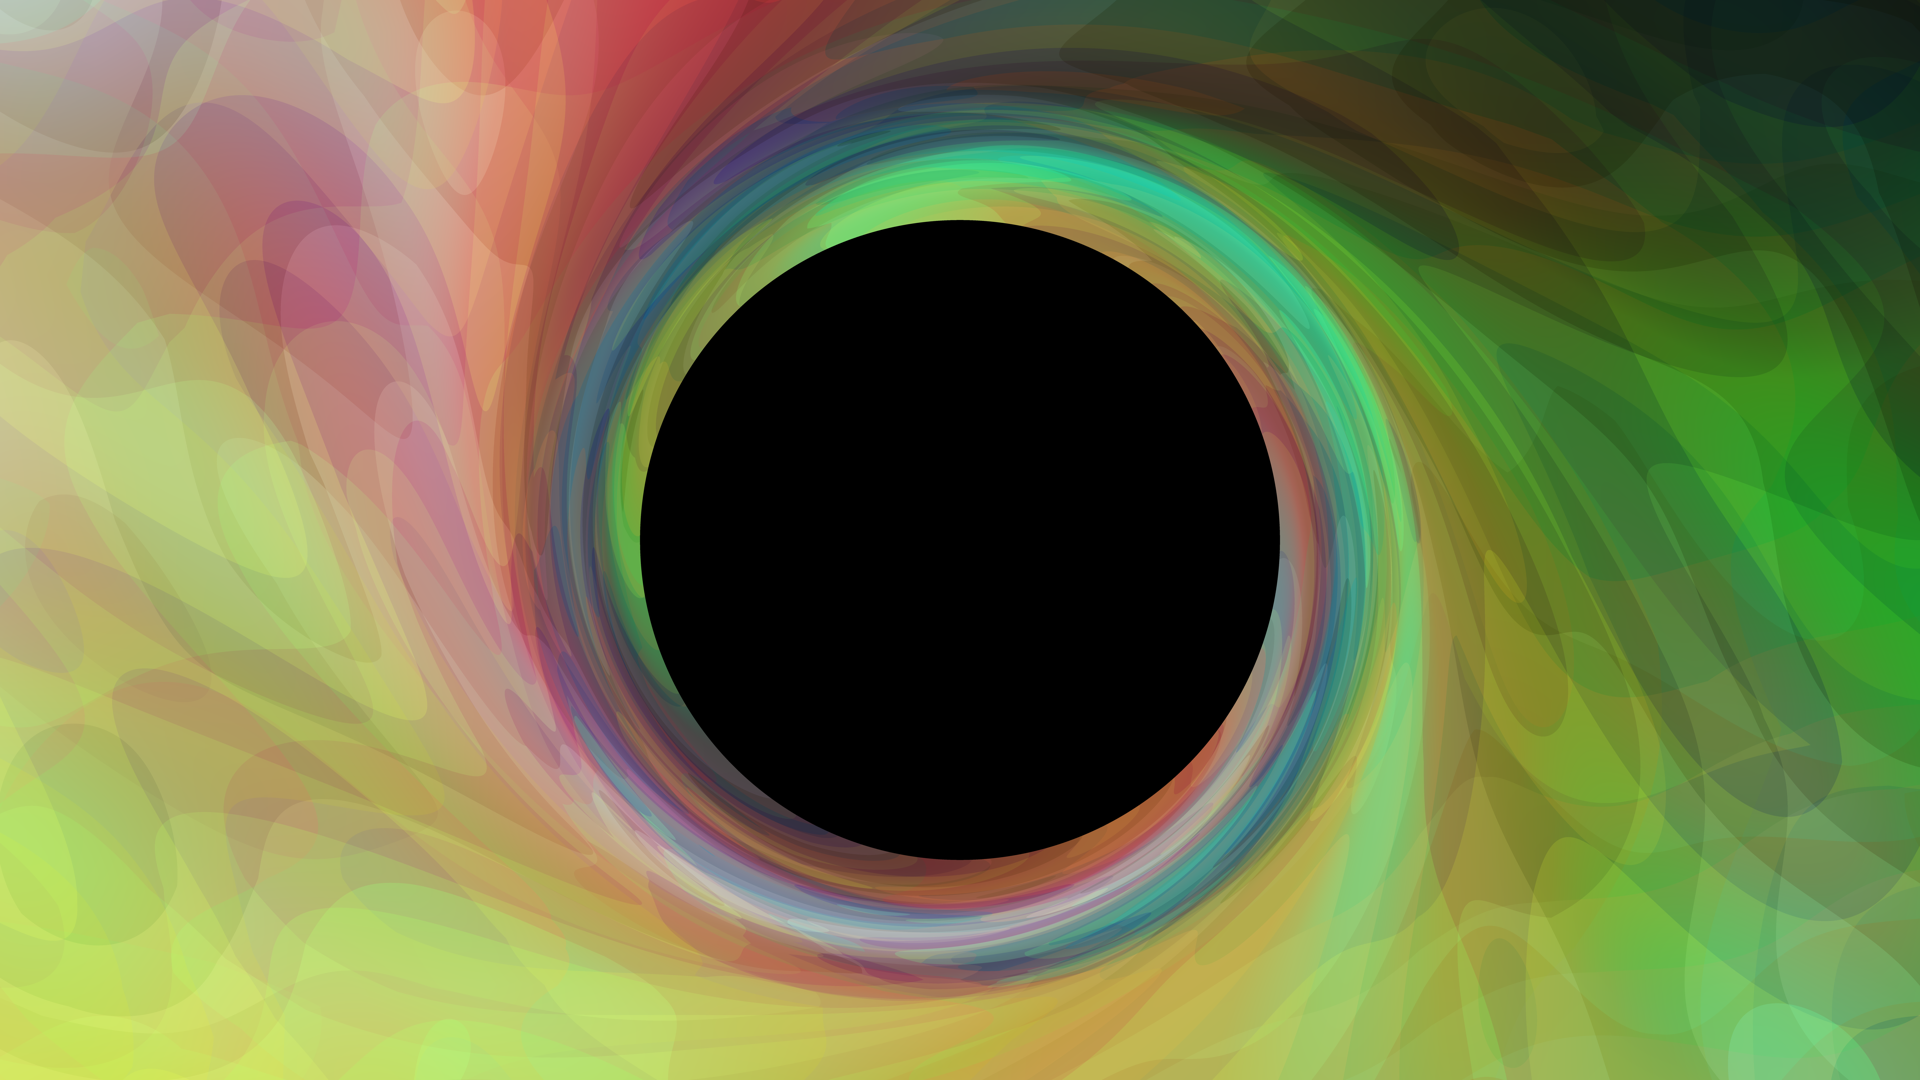

In [ ]:
color_output_rgb_matrix = stairs_generator(input_data)
Image.fromarray(color_output_rgb_matrix).resize(target_resolution, resample=PIL.Image.BICUBIC)

In [ ]:
stairs_generator = StairsGenerator()

In [ ]:
# now the hole is outside

target_resolution = (1920, 1080)
supersampling_multiplier = 4
supersampling_resolution = [size * supersampling_multiplier for size in target_resolution]
input_data = make_input_vortex(60*0, supersampling_resolution, centre, 50, 1,
                               seconds=20,
                               video_fps=60,
                               invert=True)

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


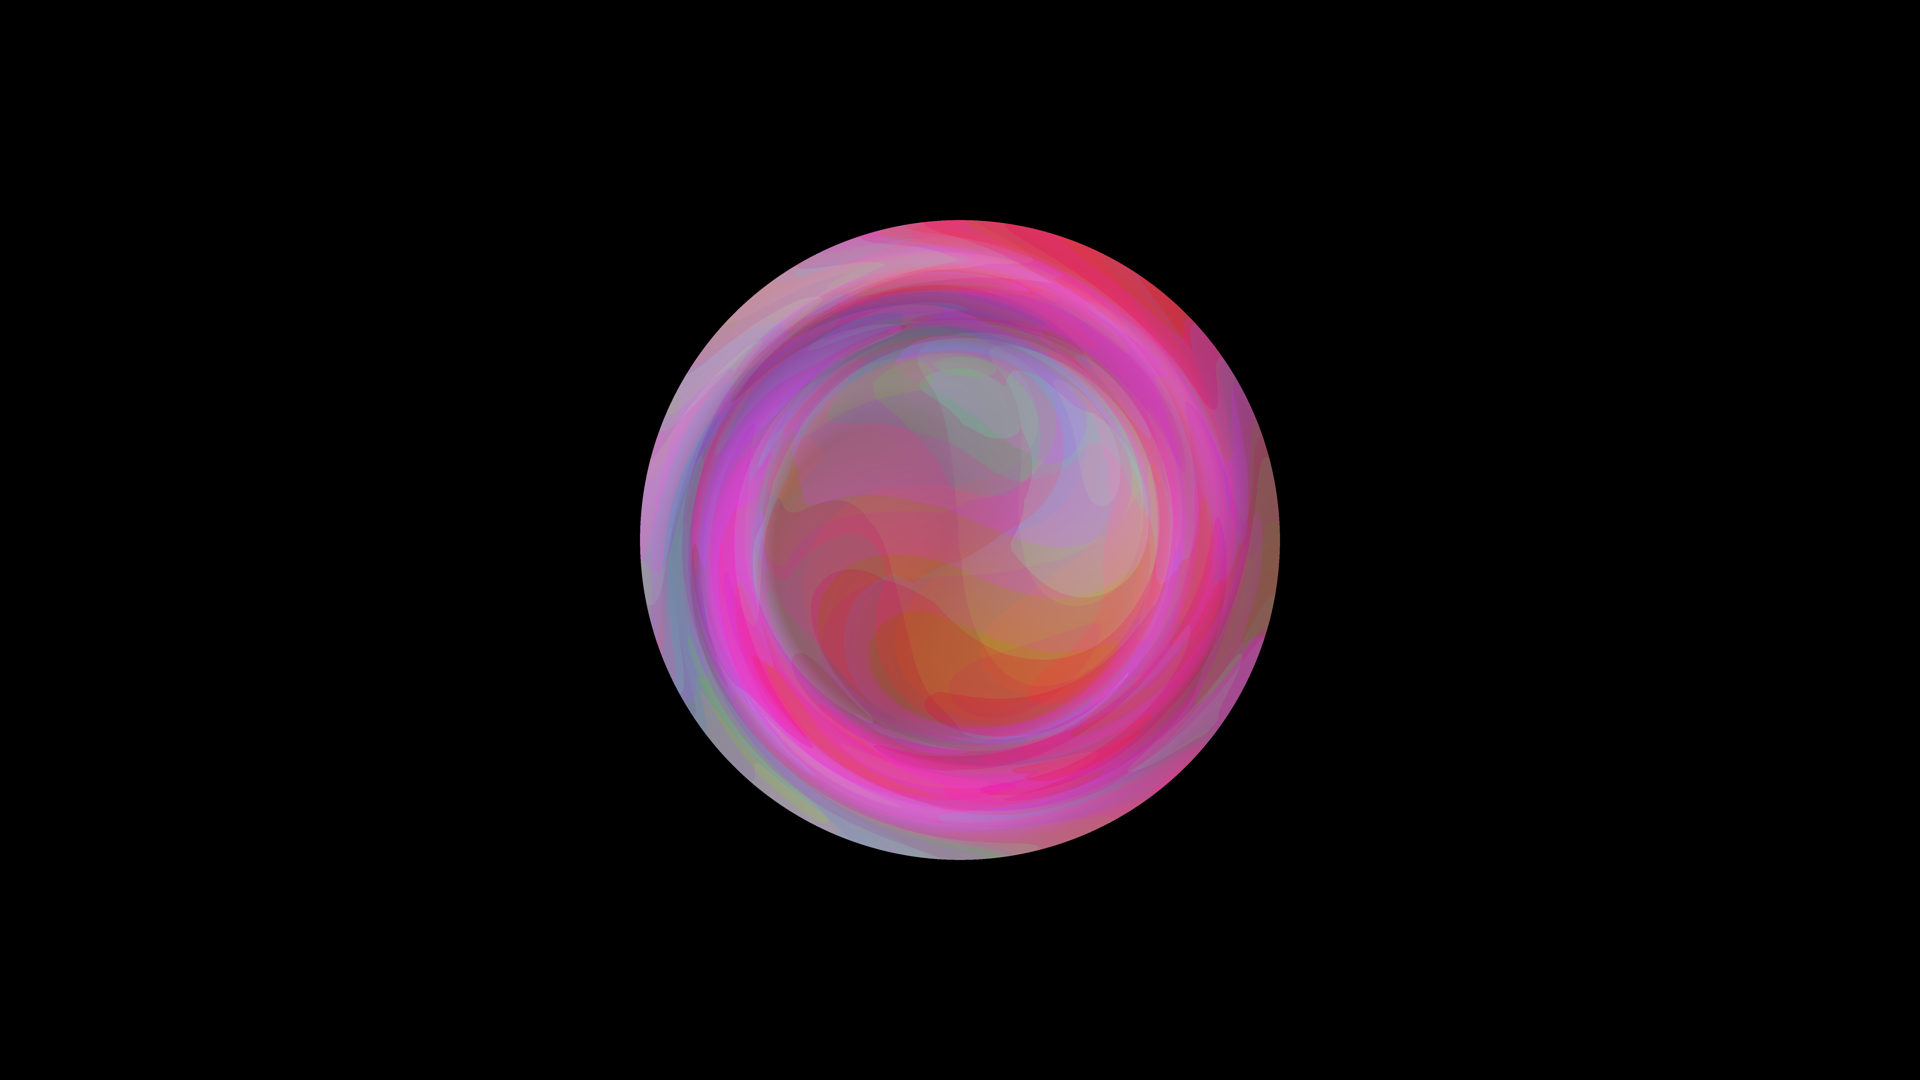

In [ ]:
color_output_rgb_matrix = stairs_generator(input_data)
Image.fromarray(color_output_rgb_matrix).resize(target_resolution, resample=PIL.Image.BICUBIC)

# Engraving an image
By using colors of a different image as additional input data, you can essentially engrave that image into the generated one

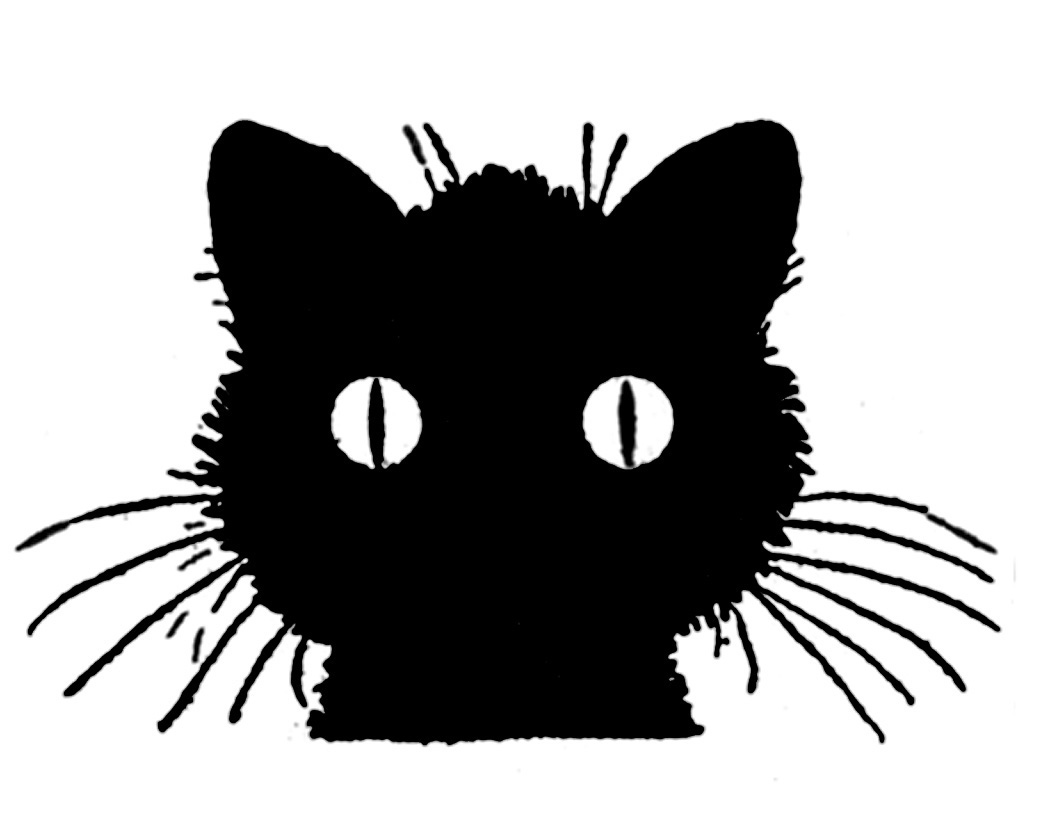

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# retrieves the image to engrave
url = 'https://thegraphicsfairy.com/wp-content/uploads/2019/08/Draw-some-Cats-GraphicsFairy.jpg'
response = requests.get(url)
image_to_engrave = Image.open(BytesIO(response.content))
image_to_engrave

In [ ]:
color_generator = ColorGenerator(
    keras.models.Sequential([
            #keras.layers.Dense(60,
      #                   kernel_initializer=keras.initializers.RandomNormal(0, 0.5)),
      #SplitActivation([tf.math.cos, tf.nn.relu6, distance]),

      keras.layers.Dense(90, kernel_initializer=keras.initializers.RandomNormal(1, 5)),
      SplitActivation([tf.math.tanh, tf.math.sin,
                      keras.layers.Dense(20, kernel_initializer=keras.initializers.RandomNormal(0, 0.05), activation=tf.sin)]),

      keras.layers.Dense(32, kernel_initializer=keras.initializers.RandomNormal(0, 5),
                        bias_initializer=keras.initializers.RandomNormal(0, 40)),
      SplitActivation([tf.math.tanh, tf.nn.relu6]),
      keras.layers.Dense(32, kernel_initializer=keras.initializers.RandomNormal(0, 1),
                        bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
      SplitActivation([tf.math.tanh,
                      lambda x: tf.nn.relu6(tf.math.log(x**2))]),
      #keras.layers.Dense(60,),
      #SplitActivation([tf.math.sin]),

      # keras.initializers.RandomNormal(0, 0.25)
      SplitActivation([tf.nn.softmax]),
      keras.layers.Dense(30, kernel_initializer=keras.initializers.RandomNormal(0, 5)),
      keras.layers.Dense(3,
                        activation='tanh'),
    ]))
color_generator.convert_color_values_to_rgb = convert_color_values_to_rgb_as_hsv

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


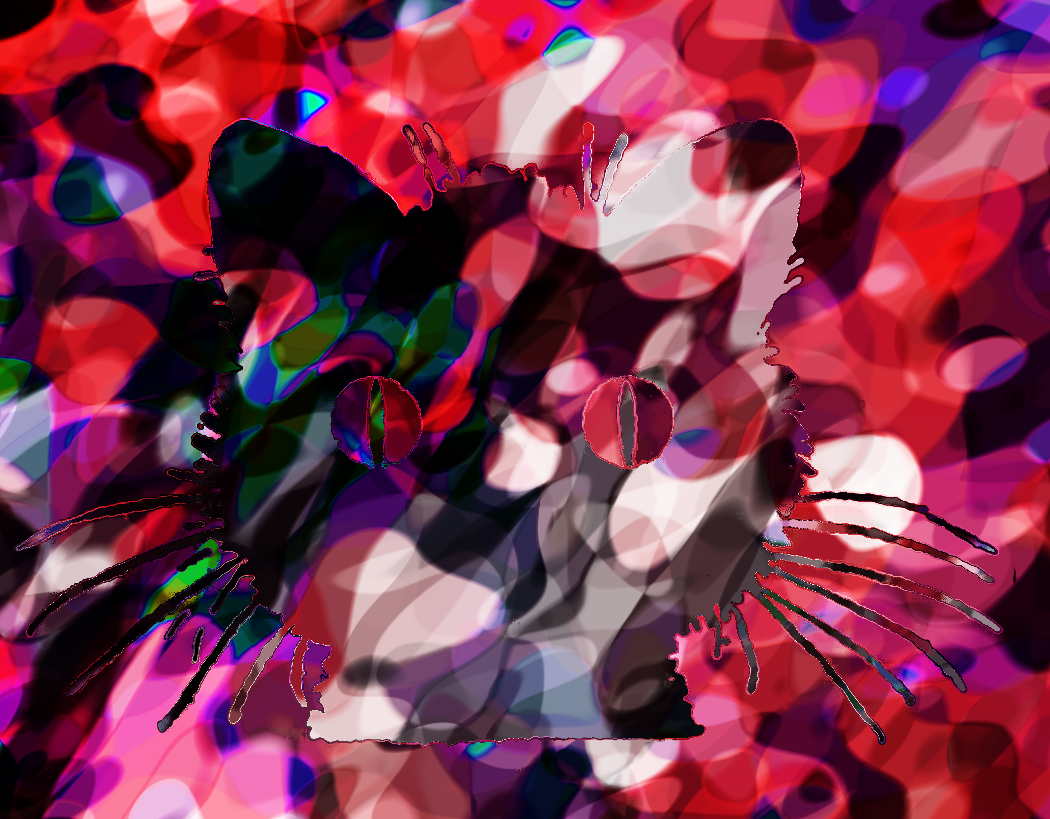

In [ ]:
res = image_to_engrave.size
centre = (0, 0)
width = 5
pixel_ratio = 1
engravement_strength = 0.5
engravement_values = (np.array(image_to_engrave) / 255)
input_matrix = create_color_generator_input_matrix(res, centre, width, pixel_ratio, effects_matrices=engravement_values * engravement_strength)
color_output_rgb_matrix = color_generator(input_matrix)
Image.fromarray(color_output_rgb_matrix)

# Animation
By slowly changing input data each frame, you can create an animation. Code for this is WIP

# Training keras model
By training the color generator keras model with the goal of immitating an image, the artwork will resemble it.
In addition, if you train the model to immitate different images on different input values, you can create animated transitions between different immitations by slowly changing input values